<h3 style="text-align:center">Logistic Regression with TensorFlow</h3>

<h3><u>Introduction</u></h3>

The goal of this notebook is to familiarize with the <u>TensorFlow</u>, the Deep Learning library build by Google in November 2015. <br>
Now it is the framework that it is the most used and we will use it in order to build a Logistic Regression model using the Iris dataset.

<h3><u>Package</u></h3>

First let's import the packages that we need to achieve our goal:

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import os

<h3>Load Iris dataset</h3>

In [2]:
# Load dataset
data = pd.read_csv('Iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


To simplify things, we will only consider 2 attributes and 2 classes.

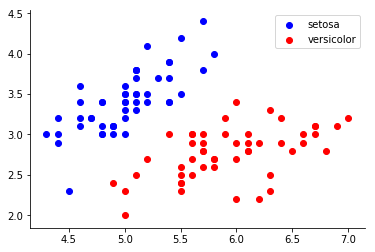

In [3]:
X = data.iloc[:100, 1:3].values
y = data.iloc[:100, 5].values

m = 100

setosa = plt.scatter(X[:50, 0], X[:50, 1], c='b', label="setosa")
versicolor = plt.scatter(X[50:, 0], X[50:, 1], c='r', label="versicolor")
plt.legend()
sns.despine()
plt.show()

We must not forget to add an extra bias feature ($x_0 = 1$) to every instance. <br>
For this, we just need to add a column full of 1s on the left of the input matrix <b>X</b>:

In [4]:
X_with_bias = np.c_[np.ones((m, 1)), X]

Let's check:

Now let's reshape y_train to make it a column vector (i.e. a 2D array with a single column):

In [5]:
y.shape

(100,)

In [6]:
y_column_vector = y.reshape(-1, 1)
y_column_vector.shape

(100, 1)

Finally, we convert the Species into number, in this case, we will impose <br>
'Iris-setosa' = 1 and 'Iris-versicolor' = 0

In [7]:
y_bin = (np.where(y_column_vector == 'Iris-setosa', 1, 0))

In [8]:
full_data = np.concatenate((X_with_bias, y_bin), axis=1)

In [9]:
full_data.shape

(100, 4)

<h3><u>Train/Test set split</u></h3>

We will split the loaded dataset into two, <b>80%</b> of which we will use to train our model and <b>20%</b> that we will hold back as a test dataset.

In [10]:
np.random.seed(42) # To make output consistent in this notebook

In [11]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    
    return data[train_indices], data[test_indices]

In [12]:
test_ratio = 0.2
train, test = split_train_test(full_data, test_ratio=test_ratio)
print("Train size:", train.shape, "Test size:", test.shape)

Train size: (80, 4) Test size: (20, 4)


In [13]:
X_train, y_train = train[:, 0:3], train[:, -1].reshape(-1, 1)
X_test, y_test = test[:, 0:3], test[:, -1].reshape(-1, 1)
print("X_train.shape:", X_train.shape, "y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape, "y_test.shape:", y_test.shape)

X_train.shape: (80, 3) y_train.shape: (80, 1)
X_test.shape: (20, 3) y_test.shape: (20, 1)


<h3>Generate training batches</h3>

In this implementation we will just pick random instances from the training set for each batch. This means that a single batch may contain the same instance multiple times, and also a single epoch may not cover all the training instances (in fact, it will generally cover only about two thirds of the instances). However, inpractice this is not an issue and it simplifies the code:

In [14]:
def random_batch(X_train, y_train, batch_size):
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

<h3><u>TensorFlow</u></h3>

Let's the reset the default graph:

In [15]:
tf.reset_default_graph()

Our preprocessed data has two input features, the sepal length and the sepal width

In [16]:
n_inputs = 2

The Logistic Regression computes a weighted sum of the inputs and then it applies the sigmoid function to the result, which gives us the estimated probability for the positive class:
$\hat p = h_{\boldsymbol{\theta}}(x) = \sigma(\boldsymbol{\theta}^{T}.\boldsymbol{x})$


Recall that $\boldsymbol{\theta}$ is the parameter vector, containing the bias term $\theta_0$ and the weights $\theta_1, \theta_2, ..., \theta_n$. <br>
The input vector $\boldsymbol{x}$ contains a constant term $x_0 = 1$, as well as all the input features $x_1, x_2, ..., x_n$.

Now let's define the <b>logistic_regression()</b> function to create the graph. We will leave out the definition of the inputs X and the targets y. We could include them here, but leaving them out will make it easier to use this function in a wide range of use cases (e.g. perhaps we will want to add some preprocessing steps for the inputs before we feed them to the Logistic Regression model).

In [17]:
def logistic_regression(X, y, initializer=None, seed=42, learning_rate=0.01):
    n_inputs_including_bias = int(X.get_shape()[1])
    
    with tf.name_scope("logistic_regression"):
        
        with tf.name_scope("model"):
            if initializer is None:
                initializer = tf.random_uniform([n_inputs_including_bias, 1], -1.0, 1.0, seed=seed)
                
            theta = tf.Variable(initializer, name="theta")
            logits = tf.matmul(X, theta, name="logits")
            y_proba = tf.sigmoid(logits)
            
        with tf.name_scope("train"):
            loss = tf.losses.log_loss(y, y_proba, scope="loss")
            optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
            training_op = optimizer.minimize(loss)
            loss_summary = tf.summary.scalar('loss_loss', loss)
            
        with tf.name_scope("init"):
            init = tf.global_variables_initializer()
            
        with tf.name_scope("save"):
            saver = tf.train.Saver()
        
    return y_proba, loss, training_op, loss_summary, init, saver

Let's create a little function to get the name of the log directory to save the summaries for Tensorboard:

In [18]:
from datetime import datetime

def log_dir(prefix=""):
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    if prefix:
        prefix += "-"
    name = prefix + "run-" + now
    return "{}/{}/".format(root_logdir, name)

Now, let's create the graph using the <b>logistic_regression()</b> function. We will also create the <b>FileWriter</b> to save the summaries to the log directory for Tensorboard.

In [19]:
n_inputs = 2 
logdir = log_dir("logreg")

X = tf.placeholder(tf.float32, shape=(None, n_inputs + 1))
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")

y_proba, loss, training_op, loss_summary, init, saver = logistic_regression(X, y)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

At last we can train the model!<br>
We will start by checking whether a previous training session was interrupted, and if so we will load the checkpoint and conitnue training from the epoch number we saved.

In [20]:
m = 100 # number of examples
n_epochs = 10001
batch_size = 10
n_batches = int(np.ceil(m / batch_size))

checkpoint_path = "/tmp/my_logreg_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_logreg_model"

Execution phase

In [21]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # If the checkpoint file exists, restore the model
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else: 
        start_epoch = 0
        sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_train, y_train, batch_size)
#             print("X_batch shape:", X_batch.shape, "y_batch.shape:", y_batch.shape)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, summary_str = sess.run([loss, loss_summary], feed_dict={X: X_test,y: y_test})
        file_writer.add_summary(summary_str, epoch)
        if epoch % 500 == 0:
            print("Epoch:", epoch, "\tLoss:", loss_val)
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))
        
    saver.save(sess, final_model_path)
    y_proba_val = y_proba.eval(feed_dict={X: X_test, y: y_test})
    os.remove(checkpoint_epoch_path)

Epoch: 0 	Loss: 1.06961
Epoch: 500 	Loss: 0.11557
Epoch: 1000 	Loss: 0.0730393
Epoch: 1500 	Loss: 0.0574932
Epoch: 2000 	Loss: 0.0484852
Epoch: 2500 	Loss: 0.0426669
Epoch: 3000 	Loss: 0.0367927
Epoch: 3500 	Loss: 0.0332635
Epoch: 4000 	Loss: 0.0313672
Epoch: 4500 	Loss: 0.0287894
Epoch: 5000 	Loss: 0.0270536
Epoch: 5500 	Loss: 0.0259418
Epoch: 6000 	Loss: 0.0237918
Epoch: 6500 	Loss: 0.0233619
Epoch: 7000 	Loss: 0.0223086
Epoch: 7500 	Loss: 0.0212911
Epoch: 8000 	Loss: 0.0199751
Epoch: 8500 	Loss: 0.0199696
Epoch: 9000 	Loss: 0.0187173
Epoch: 9500 	Loss: 0.0179285
Epoch: 10000 	Loss: 0.0178644


we can make predictions by just classifying as positive all the instances whose estimated probability is greater or equal to 0.5:

In [22]:
y_pred = (y_proba_val >= 0.5)

In [23]:
y_pred

array([[False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [False],
       [ True],
       [False],
       [ True],
       [False],
       [False],
       [ True],
       [ True]], dtype=bool)

In [24]:
np.sum(y_pred == y_test)

20

Amazing ! All the examples from the test set were classified correctly using the Logistic Regression model with TensorFlow

We can show the graph function in Juputer notebook by adding the following snippet:

In [26]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [27]:
show_graph(tf.get_default_graph())